## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import os
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical,plot_model

from keras.models import Input,Model,Sequential
from keras.layers import LSTM,Embedding,Dropout,Activation,Reshape,Dense,GRU,Add,Flatten,concatenate,Bidirectional

from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences

from keras.utils import to_categorical,plot_model
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint


In [2]:
data = pd.read_csv('/kaggle/input/data-combine/data_combined.csv')#generated from Fake News stanford.ipynb
data.head()

,Headline,Body ID,Stance,articleBody
0,Police find mass graves with at least '15 bodi...,712,unrelated,Danny Boyle is directing the untitled film\n\n...
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree,Hundreds of Palestinians were evacuated from t...
2,"Christian Bale passes on role of Steve Jobs, a...",137,unrelated,30-year-old Moscow resident was hospitalized w...
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,unrelated,(Reuters) - A Canadian soldier was shot at the...
4,Spider burrowed through tourist's stomach and ...,1923,disagree,"Fear not arachnophobes, the story of Bunbury's..."


In [4]:
data['stance_cat'] = data['Stance'].map({'agree':0,'disagree':1,'discuss':2,'unrelated':3}).astype(int)
data['Stance'].value_counts()

unrelated    36545
discuss       8909
agree         3678
disagree       840
Name: Stance, dtype: int64

In [5]:
corpus = np.r_[data['Headline'].values,data['articleBody'].values]
print(49972*2)
print(len(corpus)) # first 49972 contains the Headline and next 49972 contains the articleBody

vocabulary = []
for sentence in corpus:
    vocabulary.extend(sentence.split(' '))

vocabulary = list(set(vocabulary))
vocab_length = len(vocabulary)
print("Vocabulary Length is {0}".format(vocab_length))


99944
99944
Vocabulary Length is 64510


## Model Training Parameters

In [6]:
max_features = 5000
MAX_NB_WORDS = 24000
EMBEDDING_DIM = 50
MAX_SEQUENCE_LENGTH = 64

In [7]:
GLOVE_DIR = "../input/glove50d/"
def setup_embedding_index():
    embedding_index=dict()
    f = open(os.path.join(GLOVE_DIR,"glove.6B.50d.txt"),encoding='utf-8')
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.array(values[1:],dtype='float32')
        embedding_index[word] = coefs
    f.close()
    return embedding_index
embeddings_index = setup_embedding_index()

In [8]:
tokenizer_headline = Tokenizer(num_words=max_features, split=' ')
tokenizer_headline.fit_on_texts(data.loc[:,'Headline'].values)
vocab_headline_length = len(tokenizer_headline.word_index)+1

encoded_docs_headline = tokenizer_headline.texts_to_sequences(data.loc[:,'Headline'])
padded_docs_headline = pad_sequences(encoded_docs_headline, maxlen=16, padding='post')

print(vocab_headline_length)
word_index_headline = tokenizer_headline.word_index

NUM_WORDS_HEADLINE = vocab_headline_length

3880


In [9]:
tokenizer_body = Tokenizer(num_words=max_features, split=' ')
tokenizer_body.fit_on_texts(data.loc[:,'articleBody'].values)
vocab_body_length = len(tokenizer_body.word_index)+1

encoded_docs_body = tokenizer_body.texts_to_sequences(data.loc[:,'articleBody'])
padded_docs_body = pad_sequences(encoded_docs_body, maxlen=48, padding='post')

print(vocab_body_length)
word_index_body = tokenizer_body.word_index


NUM_WORDS_BODY = vocab_body_length
print(NUM_WORDS_BODY)

27428
27428


In [10]:

embedding_matrix_headline = np.zeros((NUM_WORDS_HEADLINE, EMBEDDING_DIM))

for word, i in tokenizer_headline.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix_headline[i] = embedding_vector
dims = len(embedding_matrix_headline[0])

print(dims)

50


In [11]:

embedding_matrix_body = np.zeros((NUM_WORDS_BODY, EMBEDDING_DIM))

for word, i in tokenizer_body.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix_body[i] = embedding_vector
dims = len(embedding_matrix_body[0])

print(dims)

50


In [12]:
print(padded_docs_headline.shape)
print(padded_docs_body.shape)

(49972, 16)
(49972, 48)


## Model Architecture

In [13]:
input_headline = Input(shape=16,name='input_headline')
embedding_layer_headline = Embedding(input_dim = vocab_headline_length,output_dim = 50,
                                     weights=[embedding_matrix_headline],
                                     input_length = 16,trainable=True)(input_headline)

# lstm_headline = LSTM(units=16)(embedding_layer_headline)

input_body = Input(shape=48,name='input_body')
embedding_layer_body = Embedding(input_dim = vocab_body_length,output_dim = 50,weights = [embedding_matrix_body],
                                 input_length=48,trainable = True)(input_body)
lstm_body = LSTM(units=48)(embedding_layer_body)

addition_layer = concatenate([embedding_layer_headline,embedding_layer_body],axis=1)

# addition_layer = concatenate([lstm_headline,lstm_body],axis=1)
lstm = LSTM(units=64,)(addition_layer)
drop = Dropout(0.25)(lstm)


output = Dense(4,activation='sigmoid')(drop)

model = Model(inputs=[input_headline,input_body],outputs=output)


model.compile(optimizer = 'adam',loss ='categorical_crossentropy',metrics = ['accuracy'])


In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_headline (InputLayer)     [(None, 16)]         0                                            
__________________________________________________________________________________________________
input_body (InputLayer)         [(None, 48)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 16, 50)       194000      input_headline[0][0]             
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 48, 50)       1371400     input_body[0][0]                 
______________________________________________________________________________________________

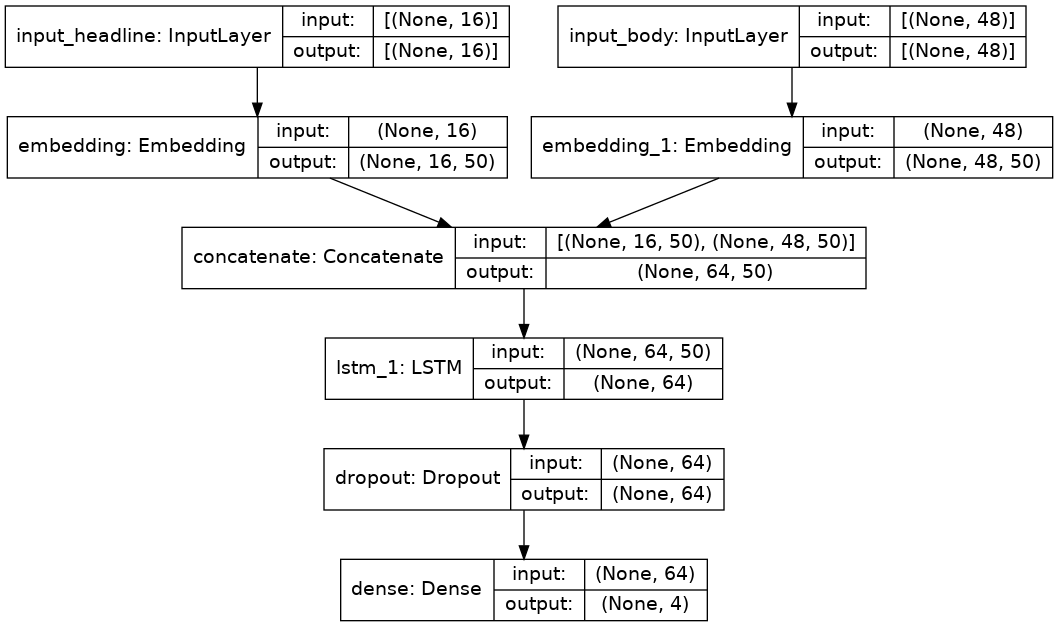

In [15]:
plot_model(model, to_file='model_glove_lstm.png', show_shapes=True, show_layer_names=True)

In [16]:
padded_docs_headline_train = padded_docs_headline[:int(len(padded_docs_headline)*0.9),:]
padded_docs_headline_test = padded_docs_headline[int(len(padded_docs_headline)*0.9):,:]

padded_docs_body_train = padded_docs_body[:int(len(padded_docs_body)*0.9),:]
padded_docs_body_test = padded_docs_body[int(len(padded_docs_body)*0.9):,:]

labels = to_categorical(data.loc[:,'stance_cat'])

labels_train = labels[:int(len(labels)*0.9),:]
labels_test = labels[int(len(labels)*0.9):,:]


## Creating Checkpoints 

For saving the latest model trained after every epoch

In [18]:
# MODELS_DIR = os.path.join("/home/abhinav/fake_news_challenge/model/glove_lstm")
filepath = os.path.join(os.getcwd(),"{epoch:02d}-{val_accuracy:.2f}.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Model Training

In [17]:
model_history = model.fit([padded_docs_headline_train,padded_docs_body_train],labels_train,epochs=40,shuffle=True,verbose=1,
                          validation_data=([padded_docs_headline_test,padded_docs_body_test],labels_test),
                                          callbacks=[checkpoint])

NameError: name 'checkpoint' is not defined

In [20]:
import pickle

# saving
with open('tokenizer_head.pickle', 'wb') as handle:
    pickle.dump(tokenizer_headline, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [21]:
import pickle

# saving
with open('tokenizer_body.pickle', 'wb') as handle:
    pickle.dump(tokenizer_body, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Model Training History

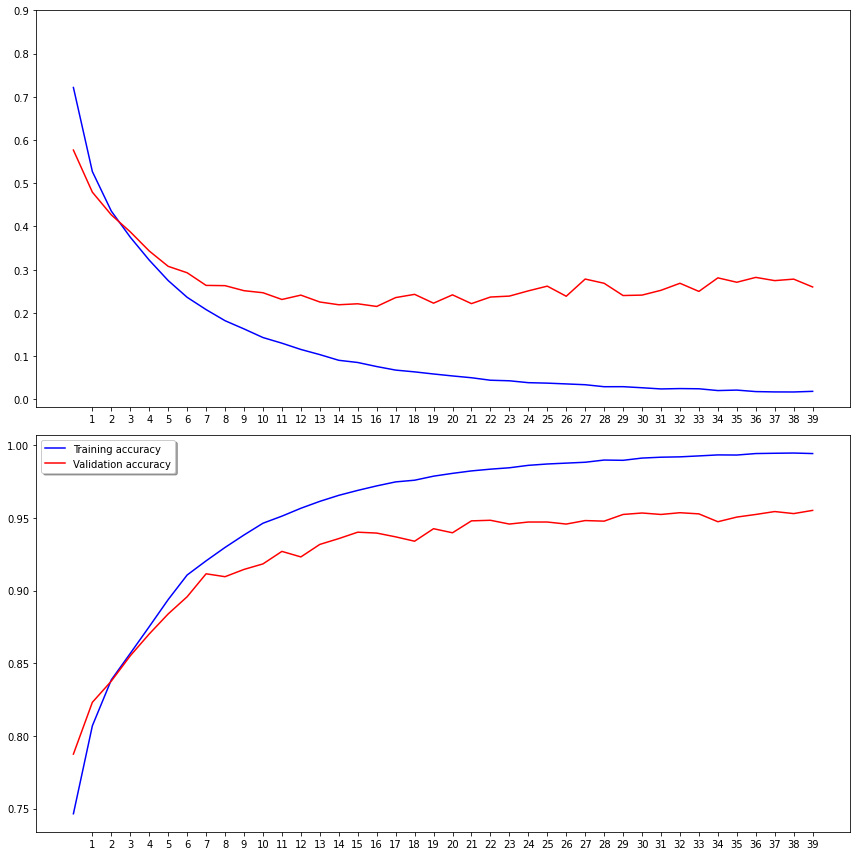

In [22]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(model_history.history['loss'], color='b', label="Training loss")
ax1.plot(model_history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 40, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(model_history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(model_history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 40, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()